In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = self.process_images(root_dir)
        self.classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(self.labels[idx])
        
        if self.transform:
            image = self.transform(image)
        return image, label

    def process_images(self, path):
        images = []
        labels = []
        for category in os.listdir(path):
            category_path = os.path.join(path, category)
            if os.path.isdir(category_path):
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    if self.is_image_file(img_path):
                        images.append(img_path)
                        labels.append(category)
        return images, labels

    def is_image_file(self, filename):
        valid_image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
        return any(filename.lower().endswith(ext) for ext in valid_image_extensions)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Less aggressive cropping
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Reduce rotation angle
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Less aggressive color jitter
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
train_dataset = BrainTumorDataset('/kaggle/input/brain-tumor-data-18k/tumordata/Training', transform=data_transforms['train'])
val_dataset = BrainTumorDataset('/kaggle/input/brain-tumor-data-18k/tumordata/Testing', transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
import torch
from torch import nn, optim
import torchvision.models as models
from torchvision.models import efficientnet_b0
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# MoCo Model Definition
class MoCo(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(MoCo, self).__init__()
        self.base_encoder = base_encoder
        self.projection_head = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
    
    def forward(self, x):
        features = self.base_encoder(x)
        features = torch.flatten(features, start_dim=1)
        projections = self.projection_head(features)
        return projections

# Load EfficientNet_B0 and remove the fully connected layer
efficientnet_encoder = efficientnet_b0(pretrained=True)
efficientnet_encoder = nn.Sequential(*list(efficientnet_encoder.children())[:-1])

# Define the MoCo model with EfficientNet_B0 as the encoder
moco_model = MoCo(efficientnet_encoder)

# Define the optimizer (Adam)
optimizer = optim.Adam(moco_model.parameters(), lr=1e-3)

# Training and Evaluation Function
def train_and_evaluate_moco(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = []
    train_accuracies, val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0
        y_true_train = []
        y_pred_train = []

        for x, labels in train_loader:
            x, labels = x.to(device), labels.to(device)
            optimizer.zero_grad()
            projections = model(x)
            
            loss = criterion(projections, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, predicted = torch.max(projections, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for x, labels in val_loader:
                x, labels = x.to(device), labels.to(device)
                projections = model(x)
                
                loss = criterion(projections, labels)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(projections, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_precision = precision_score(y_true_train, y_pred_train, average='macro')
        train_recall = recall_score(y_true_train, y_pred_train, average='macro')
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

        val_precision = precision_score(y_true_val, y_pred_val, average='macro')
        val_recall = recall_score(y_true_val, y_pred_val, average='macro')
        val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}')
        
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1)

# Helper function to plot and save loss and accuracy
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, epoch, save_dir='plots'):
    epochs = range(1, epoch + 1)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    save_path = os.path.join(save_dir, f'epoch_{epoch}.png')
    plt.savefig(save_path)

    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
moco_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s] 


MoCo(
  (base_encoder): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation):

Epoch 1/30
Train Loss: 0.3042, Train Accuracy: 0.9074
Train Precision: 0.1459, Train Recall: 0.1456, Train F1: 0.1458
Validation Loss: 0.2519, Validation Accuracy: 0.9235
Validation Precision: 0.9284, Validation Recall: 0.9261, Validation F1: 0.9243


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/30
Train Loss: 0.1079, Train Accuracy: 0.9644
Train Precision: 0.9653, Train Recall: 0.9655, Train F1: 0.9654
Validation Loss: 0.1737, Validation Accuracy: 0.9583
Validation Precision: 0.9577, Validation Recall: 0.9606, Validation F1: 0.9588
Epoch 3/30
Train Loss: 0.0877, Train Accuracy: 0.9716
Train Precision: 0.9722, Train Recall: 0.9722, Train F1: 0.9722
Validation Loss: 0.2038, Validation Accuracy: 0.9465
Validation Precision: 0.9451, Validation Recall: 0.9524, Validation F1: 0.9472
Epoch 4/30
Train Loss: 0.0641, Train Accuracy: 0.9796
Train Precision: 0.9799, Train Recall: 0.9799, Train F1: 0.9799
Validation Loss: 0.2072, Validation Accuracy: 0.9649
Validation Precision: 0.9636, Validation Recall: 0.9686, Validation F1: 0.9656
Epoch 5/30
Train Loss: 0.0550, Train Accuracy: 0.9818
Train Precision: 0.9821, Train Recall: 0.9820, Train F1: 0.9821
Validation Loss: 0.2467, Validation Accuracy: 0.9533
Validation Precision: 0.9533, Validation Recall: 0.9582, Validation F1: 0.9543


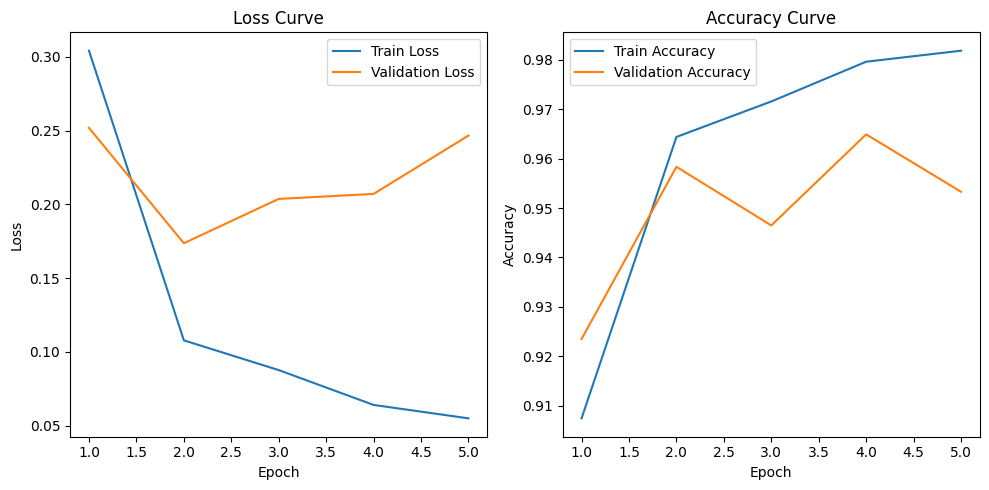

Epoch 6/30
Train Loss: 0.0472, Train Accuracy: 0.9852
Train Precision: 0.9856, Train Recall: 0.9854, Train F1: 0.9855
Validation Loss: 0.1760, Validation Accuracy: 0.9659
Validation Precision: 0.9656, Validation Recall: 0.9695, Validation F1: 0.9668
Epoch 7/30
Train Loss: 0.0410, Train Accuracy: 0.9866
Train Precision: 0.9868, Train Recall: 0.9869, Train F1: 0.9869
Validation Loss: 0.2528, Validation Accuracy: 0.9556
Validation Precision: 0.9531, Validation Recall: 0.9592, Validation F1: 0.9550
Epoch 8/30
Train Loss: 0.0400, Train Accuracy: 0.9880
Train Precision: 0.9878, Train Recall: 0.9879, Train F1: 0.9879
Validation Loss: 0.1742, Validation Accuracy: 0.9652
Validation Precision: 0.9630, Validation Recall: 0.9680, Validation F1: 0.9650
Epoch 9/30
Train Loss: 0.0443, Train Accuracy: 0.9859
Train Precision: 0.9862, Train Recall: 0.9861, Train F1: 0.9861
Validation Loss: 0.2159, Validation Accuracy: 0.9684
Validation Precision: 0.9680, Validation Recall: 0.9723, Validation F1: 0.9693


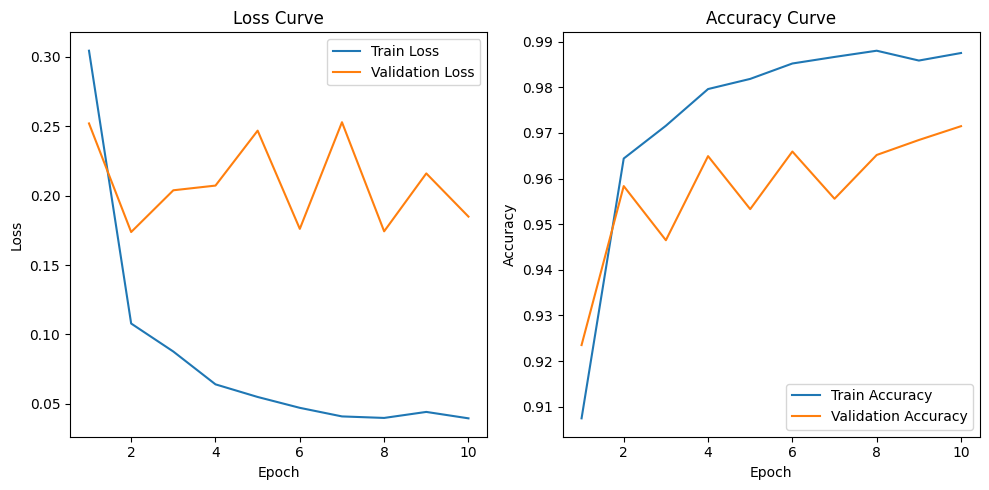

Epoch 11/30
Train Loss: 0.0310, Train Accuracy: 0.9897
Train Precision: 0.9899, Train Recall: 0.9900, Train F1: 0.9900
Validation Loss: 0.2199, Validation Accuracy: 0.9654
Validation Precision: 0.9652, Validation Recall: 0.9693, Validation F1: 0.9662
Epoch 12/30
Train Loss: 0.0386, Train Accuracy: 0.9882
Train Precision: 0.9882, Train Recall: 0.9881, Train F1: 0.9881
Validation Loss: 0.1633, Validation Accuracy: 0.9684
Validation Precision: 0.9672, Validation Recall: 0.9715, Validation F1: 0.9690
Epoch 13/30
Train Loss: 0.0257, Train Accuracy: 0.9918
Train Precision: 0.9921, Train Recall: 0.9918, Train F1: 0.9919
Validation Loss: 0.2222, Validation Accuracy: 0.9652
Validation Precision: 0.9645, Validation Recall: 0.9697, Validation F1: 0.9661
Epoch 14/30
Train Loss: 0.0331, Train Accuracy: 0.9904
Train Precision: 0.9906, Train Recall: 0.9905, Train F1: 0.9906
Validation Loss: 0.2237, Validation Accuracy: 0.9674
Validation Precision: 0.9673, Validation Recall: 0.9701, Validation F1: 0.9

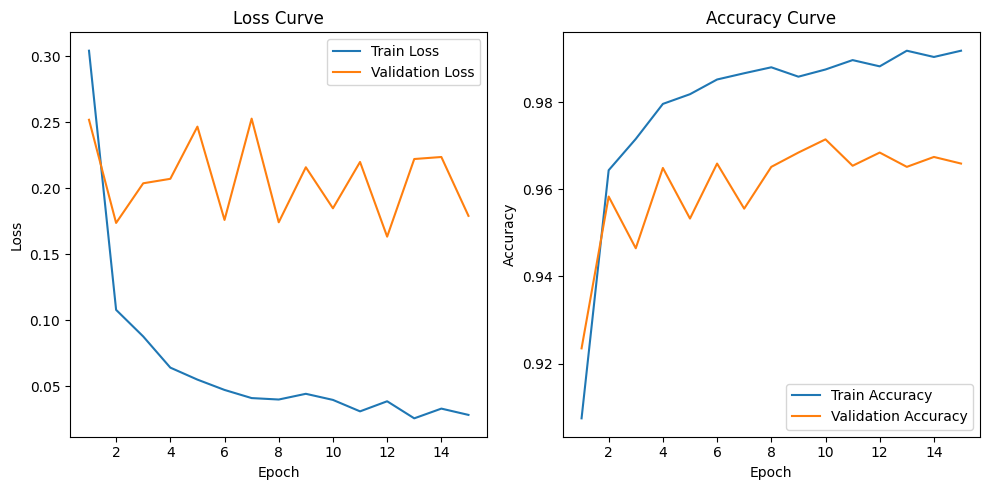

Epoch 16/30
Train Loss: 0.0354, Train Accuracy: 0.9887
Train Precision: 0.9886, Train Recall: 0.9885, Train F1: 0.9885
Validation Loss: 0.2342, Validation Accuracy: 0.9664
Validation Precision: 0.9657, Validation Recall: 0.9702, Validation F1: 0.9672
Epoch 17/30
Train Loss: 0.0216, Train Accuracy: 0.9931
Train Precision: 0.9932, Train Recall: 0.9933, Train F1: 0.9933
Validation Loss: 0.3152, Validation Accuracy: 0.9720
Validation Precision: 0.9704, Validation Recall: 0.9755, Validation F1: 0.9724
Epoch 18/30
Train Loss: 0.0236, Train Accuracy: 0.9935
Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936
Validation Loss: 0.2799, Validation Accuracy: 0.9682
Validation Precision: 0.9676, Validation Recall: 0.9719, Validation F1: 0.9690
Epoch 19/30
Train Loss: 0.0291, Train Accuracy: 0.9905
Train Precision: 0.9905, Train Recall: 0.9905, Train F1: 0.9905
Validation Loss: 0.2568, Validation Accuracy: 0.9692
Validation Precision: 0.9681, Validation Recall: 0.9726, Validation F1: 0.9

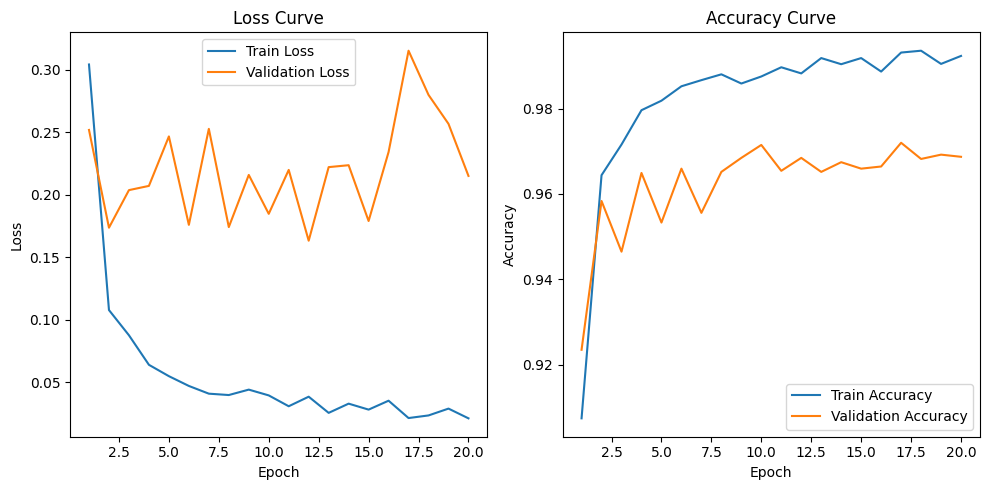

In [ ]:
train_and_evaluate_moco(moco_model, train_loader, val_loader, optimizer, device, num_epochs=30)